In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize
import functools
import json
import ast
import re

from sklearn.preprocessing import MultiLabelBinarizer
from autoimpute.imputations import MultipleImputer
from dython.nominal import cramers_v, theils_u
from pyod.models.cblof import CBLOF
from pyod.models.pca import PCA

import sys
import pickle

In [42]:
# Packages

# %pip install autoimpute
# %pip install pixiedust
# %pip install impyute
# %pip install datawig
# %pip install dython
# %pip install pyod

In [43]:
# Dataset paths
business_path = 'data/yelp_academic_dataset_business.json'
checkin_path = 'data/yelp_academic_dataset_checkin.json'
review_path = 'data/yelp_academic_dataset_review.json'
tip_path = 'data/yelp_academic_dataset_tip.json'
user_path = 'data/yelp_academic_dataset_user.json'

# Business data

За да добиеме слика околу тоа како изгледа податочното множество подолу се дадени атрибутите и нивното значење.

**business_id** - уникатен идентификатор за бизнисот составен од 22 карактери <br>
**name** - име на бизнисот <br>
**address** - адреса на бизнисот <br>
**city** - град <br>
**state** - код на state-от, 2 карактери <br>
**postal_code** - поштенски број <br>
**latitude**, **longitude** - координати на бизнисот <br>
**stars** - оценка заокружена на половина ѕвезда <br>
**review_count** - број на review-а <br>
**is_open** - дали бизнисот е отворен или затворен. Вредностите се 0 и 1 за отворен или затворен соодветно <br>
**attributes** - атрибути за биснисот. Вредноста е објект составен од име на атрибутот и вредност која може да биде проста или објект <br>
**categories** - листа на категории <br>
**hours** - објект кој мапира ден во неделата со работно време во 24 часовен формат <br>

In [44]:
business = pd.read_json(business_path, lines=True)

In [45]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


Пред да поминеме на чистење на потоците би требале да се справиме со атритубите `attributes` и `hour` кои претставуваат објекти, но и со `categories` што содржи листа од вредности. Соодветно, за полесно справување со овие атрибути истите ќе ги претавиме како посебни колони зависно од нивната вредсност.

Бидејќи ваквата операција ќе генерира голем број на вредности коишто недостасуваат, добро е да имаме увид во бројот на вредности кои недостасуваат пред "нормализација" на json вредностите:

In [46]:
print(business.isna().sum().to_string())

business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes      29045
categories        524
hours           44843


**attributes** - атрибути за биснисот. Вредноста е објект составен од име на атрибутот и вредност која може да биде проста или објект <br>

In [47]:
def is_json(value):
    try:
        json_object = ast.literal_eval(value)
    except ValueError as e:
        return False
    
    if isinstance(json_object, dict):
        return True
    
    return False

def attributes_mapper(value):
    if value is None:
        return {}
    else:
        return {k: ast.literal_eval(v) if is_json(v) else v for k, v in value.items()}
            

In [48]:
def column_unique_values(df, cols):
    filtered_df = df[cols]
    for col in filtered_df:
        print('{:<40} {:>8}'.format(col, str(filled_attr[col].unique())))

In [49]:
attribute_values = business.attributes.apply(attributes_mapper).tolist()
normalized_attributes = json_normalize(attribute_values, sep='_')
normalized_attributes = normalized_attributes.add_prefix('attr_')
# business = pd.concat([business, normalized_attributes], axis=1)
# business = business.drop('attributes', axis=1)
# unique_attributes = functools.reduce(lambda x, y: x.union(list(y.keys())), attribute_values, set())

In [50]:
normalized_attributes.columns.tolist()

['attr_BusinessAcceptsCreditCards',
 'attr_BikeParking',
 'attr_GoodForKids',
 'attr_ByAppointmentOnly',
 'attr_RestaurantsPriceRange2',
 'attr_BusinessParking_garage',
 'attr_BusinessParking_street',
 'attr_BusinessParking_validated',
 'attr_BusinessParking_lot',
 'attr_BusinessParking_valet',
 'attr_DogsAllowed',
 'attr_WiFi',
 'attr_RestaurantsAttire',
 'attr_RestaurantsTakeOut',
 'attr_NoiseLevel',
 'attr_RestaurantsReservations',
 'attr_RestaurantsGoodForGroups',
 'attr_BusinessParking',
 'attr_HasTV',
 'attr_Alcohol',
 'attr_RestaurantsDelivery',
 'attr_OutdoorSeating',
 'attr_Caters',
 'attr_WheelchairAccessible',
 'attr_AcceptsInsurance',
 'attr_RestaurantsTableService',
 'attr_HappyHour',
 'attr_Ambience_touristy',
 'attr_Ambience_hipster',
 'attr_Ambience_romantic',
 'attr_Ambience_intimate',
 'attr_Ambience_trendy',
 'attr_Ambience_upscale',
 'attr_Ambience_classy',
 'attr_Ambience_casual',
 'attr_GoodForMeal_dessert',
 'attr_GoodForMeal_latenight',
 'attr_GoodForMeal_lunch'

In [51]:
object_rgx = re.compile('^(attr_([^_]+))_')
object_attr = list(set([object_rgx.match(attr_name).group(2) for attr_name in normalized_attributes.columns.tolist() 
                    if object_rgx.match(attr_name)]))

attr_descendants = {attr: list(filter(lambda x, y=attr: re.compile(f'^attr_{y}_').match(x), 
                            normalized_attributes.columns.tolist())) for attr in object_attr}

In [52]:
# Check unique values of nested attributes
attr_values = { attr : set() for attr in object_attr }
for attr in business.attributes:
    if attr is None:
        continue
    name_mapper= lambda x: '{obj}' if x.startswith('{') else x
    
    for attr_name in object_attr: 
        if attr_name in attr:
            attr_values[attr_name].add(name_mapper(attr[attr_name]))

In [53]:
object_attr

['GoodForMeal',
 'HairSpecializesIn',
 'Ambience',
 'Music',
 'BestNights',
 'DietaryRestrictions',
 'BusinessParking']

In [54]:
attr_values

{'GoodForMeal': {'None', '{obj}'},
 'HairSpecializesIn': {'None', '{obj}'},
 'Ambience': {'None', '{obj}'},
 'Music': {'None', '{obj}'},
 'BestNights': {'None', '{obj}'},
 'DietaryRestrictions': {'None', '{obj}'},
 'BusinessParking': {'None', '{obj}'}}

In [55]:
normalized_attributes.loc[normalized_attributes['attr_BusinessParking'] == 'None', attr_descendants['BusinessParking']] = 'None'
normalized_attributes.loc[normalized_attributes['attr_BestNights'] == 'None', attr_descendants['BestNights']] = 'None'
normalized_attributes.loc[normalized_attributes['attr_DietaryRestrictions'] == 'None', attr_descendants['DietaryRestrictions']] = 'None'
normalized_attributes.loc[normalized_attributes['attr_Ambience'] == 'None', attr_descendants['Ambience']] = 'None'
normalized_attributes.loc[normalized_attributes['attr_GoodForMeal'] == 'None', attr_descendants['GoodForMeal']] = 'None'
normalized_attributes.loc[normalized_attributes['attr_Music'] == 'None', attr_descendants['Music']] = 'None'
normalized_attributes.loc[normalized_attributes['attr_HairSpecializesIn'] == 'None', attr_descendants['HairSpecializesIn']] = 'None'
normalized_attributes = normalized_attributes.drop([f'attr_{attr}' for attr in object_attr], axis=1)

**hours** - објект кој мапира ден во неделата со работно време во 24 часовен формат <br>

Тука треба да направиме разлика помеѓу оние коишто немаат поставено работно време и оние коишто не работат во одредени денови. Соодветно, бизнисите коишто не работат во одредени денови за тој ден ќе имаат вредност *`'Closed'`*.

In [56]:
functools.reduce(lambda x, y: x.union(list(y.keys())) if y is not None else x.add('None') or x, 
                 business.hours.tolist(), set())

{'Friday',
 'Monday',
 'None',
 'Saturday',
 'Sunday',
 'Thursday',
 'Tuesday',
 'Wednesday'}

In [57]:
def hours_mapper(hours):
    if hours is None:
        return {}
    
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    return {day: 'Closed' if day not in hours.keys() else hours[day] for day in days}

In [58]:
hours_values = business.hours.apply(hours_mapper).tolist()
normalized_hours = json_normalize(hours_values, sep='_')

In [59]:
normalized_hours

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,10:0-18:0,11:0-20:0,10:0-18:0,11:0-20:0,11:0-20:0,11:0-20:0,13:0-18:0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7:0-16:0,7:0-16:0,7:0-16:0,7:0-16:0,7:0-16:0,Closed,Closed
4,0:0-0:0,9:0-16:0,9:0-16:0,9:0-16:0,9:0-16:0,Closed,Closed
...,...,...,...,...,...,...,...
209388,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,Closed
209389,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209390,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-19:0
209391,0:0-0:0,7:0-19:0,7:0-19:0,7:0-19:0,7:0-19:0,9:0-19:0,9:0-19:0


**categories** - листа на категории <br>

Оваа колона ќе ја поделам на онолку колку колку што категории постојат. Вредноста за соодветната инстанца ќе биде `1` или `0` во зависност од тоа дали бизнисот припаѓа или не на категоријата соодветно. Со инстанците коишто немаат асоцирана вредност ќе се справиме подоцна. 

In [60]:
def categories_mapper(categories):
    if categories is None:
        return []
    
    name_filter = lambda x: x if x.isalpha() else False
    categories_list = [''.join(filter(name_filter, category)) for category in categories.split(', ')]
    
    return categories_list

In [61]:
categories_values = business.categories.apply(categories_mapper)
business_categories = functools.reduce(lambda x, y: x.union(categories_mapper(y)) or x, 
                                       business.categories, set())

In [62]:
mlb = MultiLabelBinarizer(sparse_output=True)
categories_matrix = mlb.fit_transform(categories_values)
categories_matrix = categories_matrix.astype('float64')
categories_matrix[business[business['categories'].isnull()].index, :] = np.nan
normalized_categories = pd.DataFrame.sparse.from_spmatrix(categories_matrix, columns=mlb.classes_)
normalized_categories = normalized_categories.add_prefix('ctg_')

/Users/darko/anaconda3/envs/nlp_finki/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [63]:
print('Number of categories: ', len(business_categories))

Number of categories:  1336


In [64]:
business_norm = pd.concat([business, normalized_attributes, normalized_categories, normalized_hours], axis=1)
business_norm = business_norm.drop(['attributes', 'categories', 'hours'], axis=1)

Моментална состојба на вредностите коишто недостасуваат.

In [65]:
print(business_norm.isna().sum().to_string())

business_id                                    0.0
name                                           0.0
address                                        0.0
city                                           0.0
state                                          0.0
postal_code                                    0.0
latitude                                       0.0
longitude                                      0.0
stars                                          0.0
review_count                                   0.0
is_open                                        0.0
attr_BusinessAcceptsCreditCards            87156.0
attr_BikeParking                          119628.0
attr_GoodForKids                          140858.0
attr_ByAppointmentOnly                    148594.0
attr_RestaurantsPriceRange2                98105.0
attr_BusinessParking_garage                94816.0
attr_BusinessParking_street                95005.0
attr_BusinessParking_validated             94816.0
attr_BusinessParking_lot       

Сега имаме множество коешто е во форма на матрица и е поразбирливо за моделите од машинско учење. Сепак, за да ги подобриме нашите резултати треба најпрвин да се справиме со вредностите коишто недостасуваат, а потоа и да ги конвертираме податоците за нивно полесна обработка.

## Чистење на податоци

***

Од првичната состојба може да се согледа дека имаме вредности коишто недостасуваат во колоните `attributes`, `categories` и `hours`. По нормализација на форматот во којшто се сместени податоците, од овие три колони произлегуваат дополнителни вредности коишто недостигаат, па истите мораме да ги пополниме. Во продолжение, за секоја колона којашто произлегува од иницијалните колони ќе се обидеме да ги пополниме `NaN` вредностите, пред се следејќи ги ограничувањата коишто ги наметнува документацијата, но и според останатите податоци во податочното множество.

**attributes** - атрибути за биснисот. Вредноста е објект составен од име на атрибутот и вредност која може да биде проста или објект <br>
**categories** - листа на категории <br>
**hours** - објект кој мапира ден во неделата со работно време во 24 часовен формат <br>


Најпрвин ќе започнеме со `attributes` вредностите коишто недостасуваат како резултат од нормализацијата на форматот. Различните атрибути коишто ги имаат бизнисите се пополнети со вредностите коишто се специфицирани во клуч-вредност паровите, но како резултат на непополнување на сите атрибути имаме `NaN` вредности. Ваквите атрибути најверојатно претставуваат дека бизнисите не го нудат/имаат она што го опишува истиот, но бидејќи значењето не е добро документирано истото ќе го поставам на `Unknown`.

In [66]:
business_norm.loc[~business['attributes'].isna(), normalized_attributes.columns.tolist()] = business_norm.loc[~business['attributes'].isna(), normalized_attributes.columns.tolist()].fillna('Unknown')

За одредување на категоријата на бизнисот, покрај останатите карактеристики, добро е да се земат во предвид атрибутите на истиот. Токму поради оваа причина, добро е да се има увид во тоа колку инстанци на коишто им недостасува категоријата имаат соодветни атрибути.

In [67]:
business.loc[business.categories.isna()].shape

(524, 14)

In [68]:
business.loc[(business.categories.isna()) & (business.attributes.isna())].shape

(523, 14)

In [69]:
business.loc[(business.categories.isna()) & (business.hours.isna())].shape

(520, 14)

In [70]:
business.loc[(business.categories.isna()) & (business.attributes.isna()) & (business.hours.isna()) ].shape

(519, 14)

Од `524` бизниси без категорија на `523` им недостасуваат атрибутите, а на `520` им недостасува работното време. Тука имаме потенцијален проблем бидејќи овие променливи би можеле да носат силен сигнал во она што би сакале да го предвидиме, односно моделираме. Како и да е, пополнувањето на овие вредности би го базирале на мал број променливи од кои поголемиот дел се нерелевантни, па **сметам дека отстранувањето на овој мал процент на инстанци е подобро решение во споредба со пополнување на истите**. Отстранувањето на овие инстанци ни дава можност пополнувањето на останатите променливи да ги базираме на категориите, а притоа да не се грижиме премногу за отстапувањата што би произлегле при пополнување.

In [71]:
business_norm = business_norm.drop(business.loc[business.categories.isna()].index)

### Претворање на атрибутите во нумерички

Пред пополнување на вредностите кои недостасуваат, со цел полесно справување со истите, атрибутите ќе ги трансформираме во нумерички. Покрај полесно справување со вредностите коишто недостасуваат, претворањето на атрибутите во нумерички ќе ни овозможи полесно анализирање, но и примена на алгоритми кои работат само со ваквите атрибути. Како и да е, со цел задржување на што е можно повеќе информации потребно е да обрнеме внимание на тоа дали атрибутите се ординални или пак номинални. Вредности на ординалните атрибути ќе ги претворам во подредени броеви.

In [72]:
tCategorical_features = ['city', 'state'] + [col for col in normalized_attributes.columns.tolist() if col in business_norm.columns.tolist()]

In [73]:
filled_attr = business_norm[tCategorical_features]
for col in filled_attr:
    print('{:<40} {:>8} {:1}'.format(col, str(filled_attr[col].unique()), len(filled_attr[col].unique())))

city                                     ['Cornelius' 'Scottsdale' 'Montreal' ... 'ARSENAL' 'Chander' 'Tempe '] 1250
state                                    ['NC' 'AZ' 'QC' 'NV' 'IL' 'ON' 'AB' 'PA' 'WI' 'SC' 'OH' 'CA' 'TX' 'NY'
 'CO' 'XWY' 'GA' 'BC' 'YT' 'HPL' 'AL' 'UT' 'VT' 'WA' 'NE' 'DOW' 'MI' 'FL'
 'AR' 'HI' 'MB' 'OR' 'AK' 'VA' 'CT' 'MO' 'DUR'] 37
attr_BusinessAcceptsCreditCards          ['True' 'Unknown' nan 'False' 'None'] 5
attr_BikeParking                         ['True' 'Unknown' nan 'False' 'None'] 5
attr_GoodForKids                         ['False' 'True' nan 'Unknown' 'None'] 5
attr_ByAppointmentOnly                   ['False' 'True' nan 'Unknown' 'None'] 5
attr_RestaurantsPriceRange2              ['3' 'Unknown' nan '4' '1' '2' 'None'] 7
attr_BusinessParking_garage              [False 'Unknown' nan 'None' True] 5
attr_BusinessParking_street              [False 'Unknown' nan 'None' True] 5
attr_BusinessParking_validated           [False 'Unknown' nan 'None' True] 5
attr_Busi

In [74]:
def fix_categorical_data(df, columns):
    for col in columns:
        unique_values = df[col].unique()
        u_rgx = re.compile("u\'([^\']+)\'")
        quote_rgx = re.compile("\'([^\']+)\'")
        
        for val in unique_values:
            if isinstance(val, bool):
                if str(val) == 'True':
                    df.loc[df[col].apply(lambda x: str(x)) == 'True', col] = 'True'
                elif str(val) == 'False':
                    df.loc[df[col].apply(lambda x: str(x)) == 'False', col] = 'False'
            
            if not isinstance(val, str):
                continue
                
            u_match = u_rgx.fullmatch(val)
            quote_match = quote_rgx.fullmatch(val)
            
            if u_match:
                df.loc[df[col] == val, col] = u_match.group(1)
            elif quote_match:
                df.loc[df[col] == val, col] = quote_match.group(1)

In [75]:
fix_categorical_data(business_norm, tCategorical_features)

Повеќето од атрибутите се номинални, па истата можеме да ја претвориме во нумеричка без да се грижиме за редоследот на вредностите. Како и да е, за да ја задржам конзистентноста за вредностите `Unknown` и `None` помеѓу колоните истите секаде ќе ги енкодирам со исти вредности.

In [76]:
ordinal_features = ['attr_RestaurantsPriceRange2', 'attr_NoiseLevel', 'attr_AgesAllowed']
nominal_features = [item for item in tCategorical_features if item not in ordinal_features ]
nominal_attrs = [item for item in normalized_attributes.columns.tolist() if item not in ordinal_features and item in business_norm.columns.tolist()]

In [77]:
def is_nan(val):
    try:
        return np.isnan(val)
    except:
        return False

def factorize_attributes(df, columns):
    for col in columns:
        values = {'Unknown': 8, 'None': 9}
        unique_values = df[col].unique()
        
        enumerated_remainings = lambda f,s: enumerate([item for item in f 
                                                       if item not in s and not is_nan(item)])
        
        if 'True' in unique_values or 'False' in unique_values:
            values.update({'True': 1, 'False': 0})
            values.update({val: 2 + i  for i, val in enumerated_remainings(unique_values, values)})
        else:
            values.update({val: i  for i, val in enumerated_remainings(unique_values, values)})
        
        df[col] = df[col].map(values)

In [78]:
factorize_attributes(business_norm, nominal_attrs)

In [79]:
business_norm.city = pd.factorize(business_norm.city)[0]
business_norm.state = pd.factorize(business_norm.state)[0]
business_norm.postal_code = pd.factorize(business_norm.postal_code)[0]

In [80]:
hour_values = set()
for col in normalized_hours:
    hour_values.update(normalized_hours[col].unique().tolist())
    
hour_values = sorted([item for item in hour_values if not is_nan(item)])
hours_map = {val: i+1 for i, val in enumerate(hour_values)}
hours_map['Closed'] = 0

In [81]:
for day in normalized_hours.columns.tolist():
    business_norm[day] = business_norm[day].map(hours_map)

Променливите `attr_RestaurantsPriceRange2`, `attr_NoiseLevel` и `attr_AgesAllowed` имаат одреден редослед, па истиот ќе се обидеме да го задржиме.

In [82]:
price_map = {'1': 0, '2': 1, '3': 2, '4': 3, 'Unknown': 8, 'None': 9}
noise_map = {'quiet': 0, 'average': 1, 'loud': 3, 'very_loud': 3, 'Unknown': 8, 'None': 9}
ages_map = {'18plus': 0, '19plus': 1, '21plus': 2, 'allages': 3, 'Unknown': 8, 'None': 9}
business_norm.attr_RestaurantsPriceRange2 = business_norm.attr_RestaurantsPriceRange2.map(price_map)
business_norm.attr_NoiseLevel = business_norm.attr_NoiseLevel.map(noise_map)
business_norm.attr_AgesAllowed = business_norm.attr_AgesAllowed.map(ages_map)

In [83]:
for col in normalized_categories.columns.tolist():
    business_norm[col] = business_norm[col].sparse.to_dense()

Доколку ги погледнеме вредностите на атрибутот `stars`, иако станува збор за вредности од типот `float`, можеме да забележиме дека истите се дискретни. За подобро да го увидиме ова можеме ја изцртаме дистрибуцијата и хистограмот на променливата.

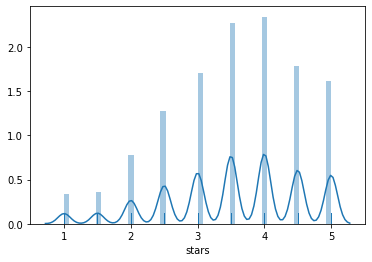

In [84]:
sns.distplot(business_norm['stars'], rug=True, kde=True)

In [85]:
business_norm['stars'].unique()

array([3.5, 5. , 2.5, 4.5, 3. , 4. , 1.5, 2. , 1. ])

In [86]:
business_norm.stars = business_norm.stars.astype(np.str)
stars_map = {'1.0': 0, '1.5': 1, '2.0': 2, '2.5': 3, '3.0': 4, '3.5': 5, '4.0': 6, '4.5': 7, '5.0': 8}
business_norm.stars = business_norm.stars.map(stars_map)

Отстранување на колони каде 95%+ од вредностите недостасуваат

In [87]:
def filter_empty_columns(df, empty_percent=.95):
    df = df.copy()
    column_status = df.isna().sum()
    column_count = (df.shape[1], df.shape[1])
    
    for col in df:
        if column_status[col] > (df.shape[0] * empty_percent):
            df = df.drop(col, axis=1)
            
    column_count = (column_count[0], df.shape[1])
    print('Columns:', column_count[0], '->', column_count[1])
    
    return df

In [88]:
business_norm = filter_empty_columns(business_norm)

Columns: 1435 -> 1435


### Пополнување на вредностите коишто недостасуваат

За пополнување на вредностите ќе користиме модели коишто ги предвидуваат овие вредности врз основа на други променливи. Поради ограничената меморија и процесирачка моќ пополнувањето го извршивме т.ш секоја колона ја пополнивме еднаш. Доколку имавме повеќе ресурси би примениле `multiple imputing` (пополнување на една колона повеќе пати), со што од тие резултати би можеле да добиеме поверодостојно пополнување.

Пополнувањето на вредностите за колоните коишто се однесуваат на **атрибутите на бизнисот** е извршено со `multinomial logistic regression`. Овој метод дава предвидувања врз основа на одредено множество на променливи, кои во овој случај беа категориите на бизнисот. 

Пополнувањето на вредностите на колоните коишто се однесуваат на **работните саати на бизнисот** е извршено со случајно избирање на вредности од дистрибуцијата на колоните. Го избравме овој метод бидејќи имаме голем број на категориски вредности и користење на друг метод би побарувал поголема процесирачка моќ.


In [94]:
non_predictor_col_names = ['business_id', 'name', 'address', 'latitude', 'longitude']
non_predictor_columns = business_norm[non_predictor_col_names]
business_norm = business_norm.drop(non_predictor_col_names, axis=1)

In [90]:
business_cols = business_norm.columns.tolist()
# cat_strategy = {col:'binary logistic' for col in normalized_categories.columns.tolist() if col in business_cols}
attr_strategy = {col:'multinomial logistic' for col in normalized_attributes.columns.tolist() if col in business_cols}
hours_strategy = {col:'categorical' for col in normalized_hours.columns.tolist() if col in business_cols}
columns_strategy = {**attr_strategy, **hours_strategy}

In [91]:
predictors_list = [col for col in normalized_categories.columns.tolist() if col in business_norm.columns.tolist()]

In [92]:
# Commented since it is a long running operation (12h +). The results are loaded from a pickle file.

# mi = MultipleImputer(n=1, strategy={'Monday': 'categorical'}, predictors=predictors_list, return_list=True)
# mi_data_full = mi.fit_transform(business_norm)

In [6]:
business_norm = pd.read_pickle('./inputs/numerical_filled_df_wStars.pickle', 'gzip')
# business_norm[non_predictor_col_names] = non_predictor_columns

In [36]:
# Helper funcs
def outlier_info(data, x, rug=True, kde=True):
    fig = plt.figure(constrained_layout=True, figsize=(8, 6))
    gs = fig.add_gridspec(2, 3)
    
    f_histogram = fig.add_subplot(gs[:, :-1])
    f_histogram.set_title('Histogram')
    sns.distplot(data[x], rug=rug, kde=kde)
    
    f_box = fig.add_subplot(gs[:, 2])
    f_box.set_title('Boxplot')
    sns.boxplot(data[x], orient='v')

### Outliers

Кога станува збор за outliers, зборуваме за вредности коишто отстапуваат од останатите податоци, без разлика дали станува збор за екстрамни вредности или пак вредности коишто се надвор од некој опсег. Како и да е, во нашите податоци имаме една нумеричка променлива `review_count`, додека останатите се категориски променливи. Кај категориските променливи немаме некакви отстапувања на ниво на една променлива бидејќи сите вредности се одредени однапред, па затоа би требале да бараме аномалии на ниво на повеќе променливи.

За детекција на аномалии на ниво на цели записи ќе користиме кластерирање, односно [Clustering Based Local Outlier Factor (CBLOF)](https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.cblof.CBLOF). Со овој алгоритам се прават модели за кластерирање и се доделува "anomaly score" на кластерите во зависност од нивната оддалаченост од големи кластери (имаме мали и големи кластери). Како алтернатива може да се користи и [Principal Component Analysis (PCA) Outlier Detector](https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.pca.PCA).

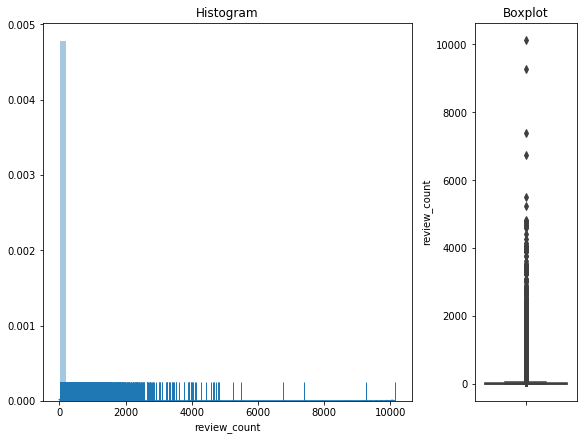

In [39]:
outlier_info(business_norm, 'review_count', rug=True)

Од boxplot-от можат да се забележат повеќе вредности коишто се поголеми од екстремната вредност, односно надвор од "опсегот" кои го опфаќаат "whiskers". Имаме неколку сомнителни вредности, особено оние коишто се во рангот 6000-11000, но бидејќи станува збор за број на оценки тоа не значи дека истите се аномалии.

In [96]:
business_full = business_norm.copy()
business_full[non_predictor_col_names] = non_predictor_columns
business_full.loc[business_full.review_count > 6000]

,city,state,postal_code,stars,review_count,is_open,attr_BusinessAcceptsCreditCards,attr_BikeParking,attr_GoodForKids,attr_ByAppointmentOnly,...,Wednesday,Thursday,Friday,Saturday,Sunday,business_id,name,address,latitude,longitude
81545,6,3,16,6,10129,1,1.0,0.0,1.0,0.0,...,1921,1921,1921,2026,2026,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,3570 S Las Vegas Blvd,36.115929,-115.176238
83020,6,3,16,6,6751,1,1.0,1.0,1.0,0.0,...,1,1,1,1,1,f4x1YBxkLrZg652xt2KR5g,Hash House A Go Go,3535 Las Vegas Blvd,36.118181,-115.171580
118008,6,3,16,6,9264,1,1.0,0.0,1.0,1.0,...,1828,1828,1777,1777,1828,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi,3655 Las Vegas Blvd S,36.112859,-115.172434
147379,6,3,16,5,7383,1,1.0,0.0,1.0,0.0,...,2022,2022,2026,2026,2022,K7lWdNUhCbcnEvI0NhGewg,Wicked Spoon,"The Cosmopolitan Of Las Vegas, Level 2, The Ch...",36.109550,-115.176155


Бизнисите се наоѓаат во Las Vegas, па бројот на оценки може да е реален бидејќи градот секојдневно е посетуван од илјадници луѓе. Овие вредности нема да ги отстраниме.

In [4]:
# Long running. 

# scaler = StandardScaler().fit(business_norm)
# business_tst = business_norm.copy()
# business_tst[business_norm.columns.tolist()] = scaler.transform(business_norm)
# business_tst.to_pickle('./long_running/business_cblof_standardized.pickle', 'gzip')

# cblof = CBLOF(n_clusters=10, n_jobs=1)
# cblof.fit(business_tst.values)

# RAM problems
# pca = PCA(n_components='mle', standardization=True)
# pca.fit(business_norm.values)

In [5]:
# Load fit model

cblof = pickle.loads(open('./long_running/pyod_cblof_model_v2.pickle', 'rb').read())

/Users/darko/anaconda3/envs/nlp_finki/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
# cblof_outlier = cblof.predict(business_tst.values)
# cblof_outlier_P = cblof.predict_proba(business_tst.values)
# business_outliers = business_full.assign(outlier = pd.Series(cblof_outlier, index=business_full.index).values, outlier_P = pd.Series(cblof_outlier_P[:, 1], index=business_full.index), outlier_NP = pd.Series(cblof_outlier_P[:, 0], index=business_full.index).values )

business_outliers = pd.read_pickle('./long_running/business_cblof_out_standardized.pickle', 'gzip')

Ќе ги отстраниме оние инстанци за кои алгоритмот е посигурен дека станува збор за аномалија.

In [8]:
business_outliers[business_outliers.outlier_P > 0.7].shape

(48, 1433)

In [7]:
business_norm = business_norm.drop(business_outliers[business_outliers.outlier_P > 0.7].index)

### Корелација помеѓу променливите

Кога станува збор за анализа на податоци и моделирање, разбирањето на поврзаноста помеѓу променливите може да ни биде од корист. Доколку имаме корелација помеѓу една или повеќе променливи тогаш може да се јават проблеми со некои од алгоритмите, дали од аспект на тоа колку добро ги моделираат податоците, перформансите за време на тренирање или пак ограничената прецизност. Овие проблеми може да бидат митигирани со користење на PCA, но сепак и таму имаат значително влијание врз изборот на компонентите. 

Како и да е, добро е да се отстранат високо корелираните променливи бидејќи носат "иста" информација, а всушност она што го сакаме е да имаме додаваме дополнителни информации. Сепак, нема правила за некој threshold околу тоа колкава би требало да биде корелацијата помеѓу променливите за да отстраниме дел од нив, па затоа ќе ги отстранам променливите со корелација 0.90+ (повеќето од отстранетите се со корелација 1.0 и ~.93, ~.94), а дополнително потоа ќе извршиме и редукција димензионалноста на податоците со користење на PCA.

Користевме Pearson correlation coefficient за променливите коишто беа one-hot енкодирани, додека за корелацијата помеѓу номиналните/ординалните променливи и помеѓу непрекинати-категориски променливи би користеле Theil’s U, односно Correlation Ratio. (Бидејќи не успеавме да најдеме имплементација којашто ефикасно работи со матрици применивме корелација само на one-hot енкодираните променливи).

За подобра визуелизација на променливите ќе користиме heatmap со што ќе имаме некоја слика за корелираноста на променливите, но поради големиот број на променливи ќе ги прикажам само оние коишто имаат корелација  < -0.5 или > 0.5. На визуелизацијата имаме околу 180 променливи, па е малку тешко да се увидат конкретните променливи, но ни дава увид во тоа дека имаме повеќе променливи коишто имаат перфектна корелираност (Може да се зумира, а сликата е достапна и во фолдерот). 

In [95]:
# Can be long running
# pearson_corr = business_norm[normalized_categories.columns.tolist()].corr()

person_corr = pd.read_pickle('./long_running/pearson_corr.pickle', 'gzip')

In [105]:
corr_df_triple = pearson_corr.stack().reset_index().rename(columns={'level_0':'Variable_1', 'level_1':'Variable_2', 0:'Correlation'})
corr_df = corr_df_triple.drop(corr_df_triple.loc[corr_df_triple.Variable_1 == corr_df_triple.Variable_2].index)
corr_df = corr_df.loc[corr_df.Correlation.abs() > 0.5]
corr_df = corr_df.pivot(index='Variable_1', columns='Variable_2', values='Correlation')

In [106]:
corr_df.shape

(186, 186)

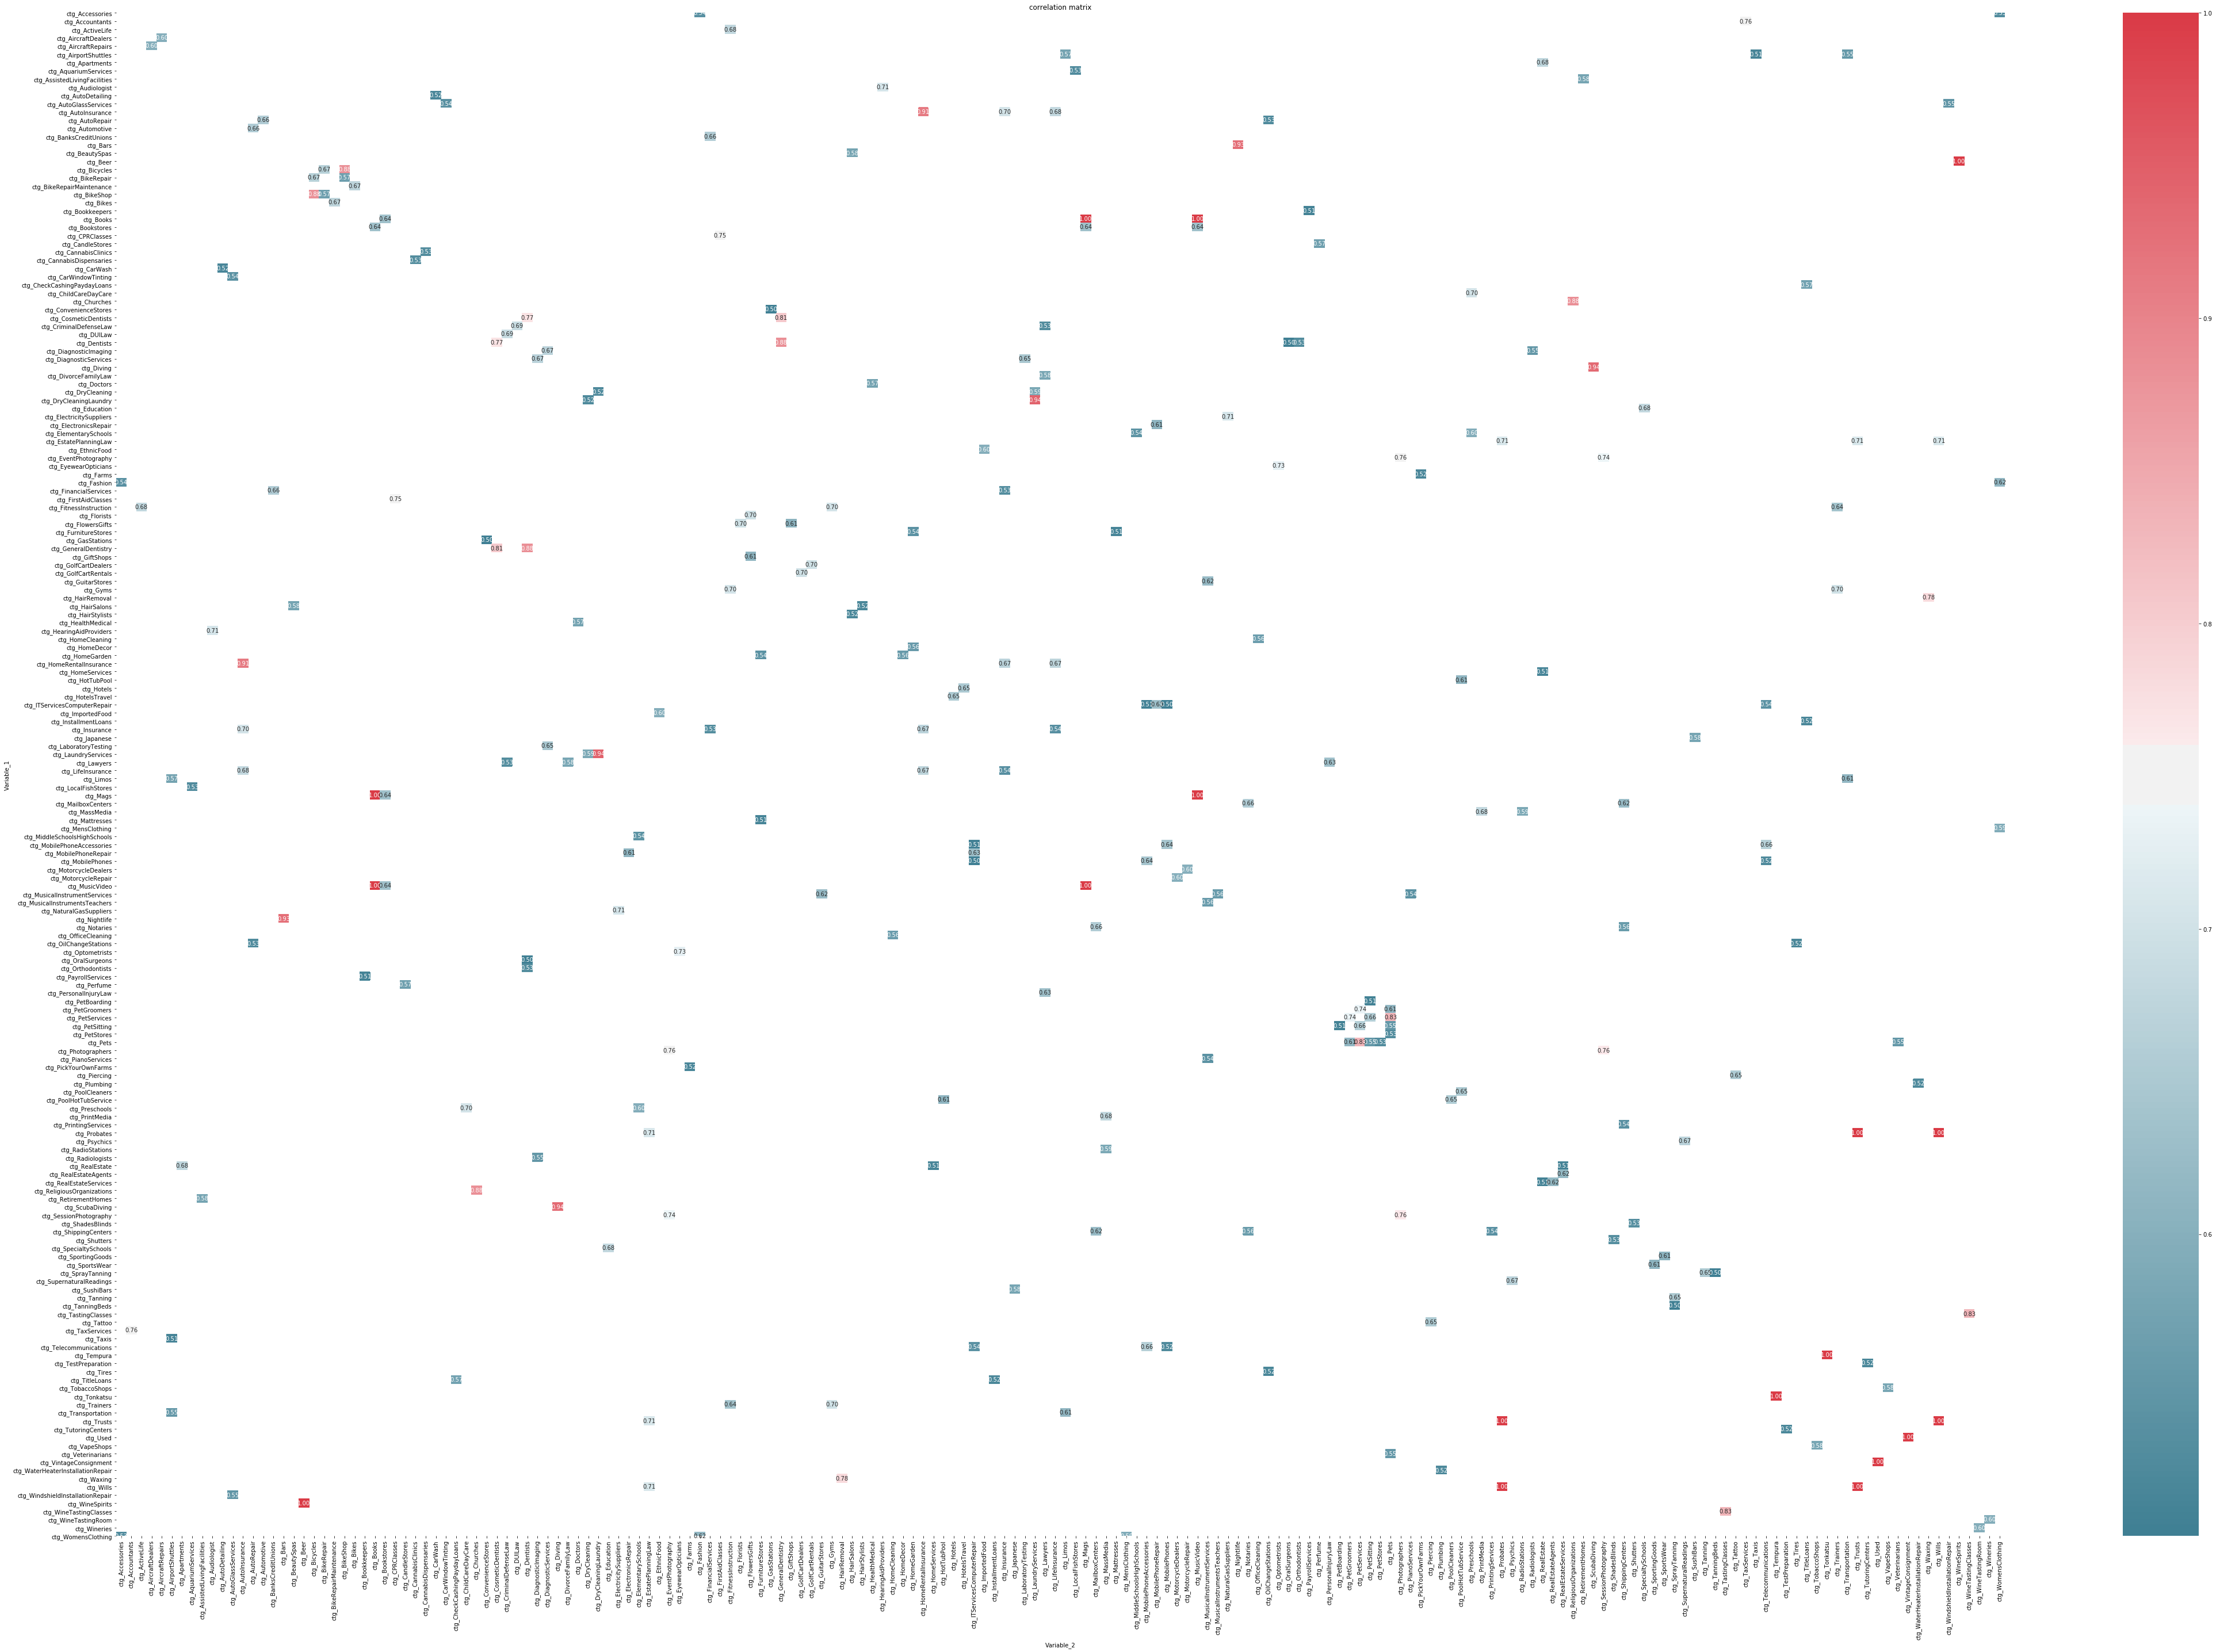

In [108]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(60, 40))
sns.heatmap(corr_df, cmap=colormap, annot=True, fmt=".2f")
ax.set_title('correlation matrix')
plt.tight_layout()
plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

In [111]:
corr_df_triple.loc[(corr_df_triple.Correlation.abs() > 0.85) & (corr_df_triple.Variable_1 != corr_df_triple.Variable_2)]

,Variable_1,Variable_2,Correlation
104803,ctg_AutoInsurance,ctg_HomeRentalInsurance,0.913732
139767,ctg_Bars,ctg_Nightlife,0.929796
158972,ctg_Beer,ctg_WineSpirits,1.000000
171142,ctg_Bicycles,ctg_BikeShop,0.881913
179152,ctg_BikeShop,ctg_Bicycles,0.881913
207811,ctg_Books,ctg_Mags,1.000000
207887,ctg_Books,ctg_MusicVideo,1.000000
343041,ctg_Churches,ctg_ReligiousOrganizations,0.884287
460093,ctg_Dentists,ctg_GeneralDentistry,0.883331
487366,ctg_Diving,ctg_ScubaDiving,0.935399


Отстранетите променливи се изберени на начин што ќе ги задржат генералните променливи, односно променливи што опфаќаат повеќе преклопувања.

In [11]:
# For removal
corr_features = ['ctg_Beer', 'ctg_Mags', 'ctg_MusicVideo', 'ctg_ScubaDiving', 'ctg_DryCleaningLaundry', 'ctg_Bars', 'ctg_Trusts', 'ctg_Wills', 'ctg_Tonkatsu', 'ctg_VintageConsignment']

In [12]:
business_norm = business_norm.drop(corr_features, axis=1)

In [13]:
from sklearn.preprocessing import StandardScaler

### Standardization

Податоците ќе ги стандардизираме, односно ќе ги скалираме т.ш имаат својства на стандардна нормална распределба со `mean=0` и `sd=0`. Ова е потребно бидејќи голем дел од алгоритмите (пр. SVM, K-nearest neighbors, logistic regression, PCA) имаат потреба променливите да се нормализирани/стандардизирани, што може да овозможи подобри резултати, но и значително да го забрза нивното извршување.

In [14]:
scaler = StandardScaler().fit(business_norm)
business_norm[business_norm.columns.tolist()] = scaler.transform(business_norm)

In [15]:
business_norm.head()

,city,state,postal_code,stars,review_count,is_open,attr_BusinessAcceptsCreditCards,attr_BikeParking,attr_GoodForKids,attr_ByAppointmentOnly,...,ctg_Yoga,ctg_Ziplining,ctg_Zoos,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,-0.459810,-1.233916,-0.521186,-0.040666,-0.008177,0.490199,-0.691471,-1.055165,-1.627593,-1.513194,...,-0.076279,-0.007581,-0.015782,-0.919469,-0.951183,-1.190220,-0.975310,-0.973535,-0.680236,0.062544
1,-0.449026,-0.889474,-0.520914,1.428786,-0.267400,0.490199,1.409586,0.891661,-1.334561,-1.234620,...,13.109732,-0.007581,-0.015782,-0.896002,-0.940177,-0.957869,1.179718,-0.952517,-0.988446,-0.661520
2,-0.438243,-0.545033,-0.520642,1.428786,-0.259299,0.490199,1.409586,0.891661,0.716662,-1.234620,...,-0.076279,-0.007581,-0.015782,-1.011203,0.943978,-1.284267,0.931146,0.695766,0.747661,-0.551976
3,-0.427460,-0.200591,-0.520370,-1.020301,-0.275500,-2.039989,-0.691471,-1.055165,0.716662,-1.513194,...,-0.076279,-0.007581,-0.015782,0.907751,0.713962,0.705105,0.703659,0.700191,-0.988446,-0.661520
4,-0.416676,-0.889474,-0.520098,0.938969,-0.089184,0.490199,-0.691471,0.891661,0.716662,-1.234620,...,-0.076279,-0.007581,-0.015782,-1.010137,1.166291,1.159850,1.159744,1.154852,-0.988446,-0.661520


In [17]:
from sklearn.decomposition import PCA

### Dimensionality Reduction

Во податочното множество имаме висока димензионалност (~1400 променливи) која е директна причина за појава на проблемите кои се асоцирани со ["curse of dimensionality"](https://en.wikipedia.org/wiki/Curse_of_dimensionality). Со овие проблеми се соочивме во препроцесирањето на податоците, но значителен проблем би ни претставувале и при користење на алгоритмите за моделирање од машинско учење. 

За да ја намалиме димензионалноста на податоците ќе користиме Principal Component Analysis (PCA) со што ќе се обидеме да задржиме добар дел од варијансата, а притоа да конструираме минимален број на principal components.

In [18]:
# Trained on Colab
# pca = PCA()
# pca.fit(business_norm)

pca = pickle.loads(open('./long_running/pca_model_business_norm.pickle', 'rb').read())

/Users/darko/anaconda3/envs/nlp_finki/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


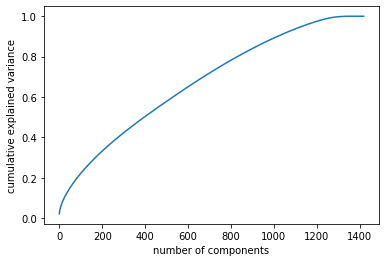

In [19]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Не прави добра редукција, пробувам неколку методи сега

<hr>

# Review data

Податочното множество ги содржи следниве атрибути.

**review_id** - уникатен идентификатор на review-то составен од 22 карактери <br>
**user_id** - уникатен идентификатор на корисникот кој го оставил review-то составен од 22 карактери <br>
**business_id** - уникатен идентификатор за бизнисот составен од 22 карактери <br>
**stars** - оценка со која е пропратен review-от <br>
**date** - датум на кој е поставен review-от во формат YYYY-MM-DD <br>
**text** - содржина на review-от <br>
**useful** - колку пати review-от е оценет како корисен <br>
**funny** - колку пати review-от е оценет како смешен <br>
**cool** - колку пати review-от е оценет како cool <br>

<hr>

# User data

Податочното множество ги содржи следниве атрибути.

**user_id** - уникатен идентификатор на корисникот составен од 22 карактери <br>
**name** - име на корисникот <br>
**review_count** - колку review-а остивил корисникот <br>
**yelping_since** - датум кога е направен акаунтот YYYY-MM-DD <br>
**useful** - број на оценки "корисно" <br>
**funny** - број на оценки "смешно" <br>
**cool** - број на оценки "cool" <br>
**fans** - колку фанови има корисникот <br>
**elite** - низа од години во кои корисникот имал статус elite <br>
**average_stars** - просечна оценка што ја оставил корисникот <br>

Какви комплименти се добиени од корисникот:
**compliment_hot** <br>
**compliment_more** <br>
**compliment_profile** <br>
**compliment_cute** <br>
**compliment_list** <br>
**compliment_note** <br>
**compliment_plain** <br>
**compliment_cool** <br>
**compliment_funny** <br>
**compliment_writer** <br>
**compliment_photos** <br>